In [2]:
library(tidyverse)
source("plotting_common.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [3]:
read_problem = function(filepath) {
    dir = gsub("_", "-", gsub("\\..*$", "", basename(dirname(filepath))))
    robust = grepl("robust", filepath)
    read_csv(filepath, col_types = cols()) %>% mutate(bal=dir, robust=robust)
}
read_problems = function(filepat) {
    bind_rows(lapply(Sys.glob(file.path("../ba-problems/*.problem", filepat)), read_problem))
}

In [4]:
df = bind_rows( read_problems("parallel_pbjacobi_np*.csv")
              , read_problems("parallel_gamg_np*.csv")
              )

Parsed with column specification:
cols(
  problem = col_double(),
  solver = col_character(),
  cost = col_double(),
  cost_change = col_double(),
  gradient_norm = col_double(),
  step_norm = col_double(),
  damping = col_double(),
  iters = col_double(),
  setup_time = col_double(),
  solve_time = col_double(),
  iter_time = col_double(),
  eta = col_double(),
  cameras = col_double(),
  points = col_double(),
  flops = col_double()
)



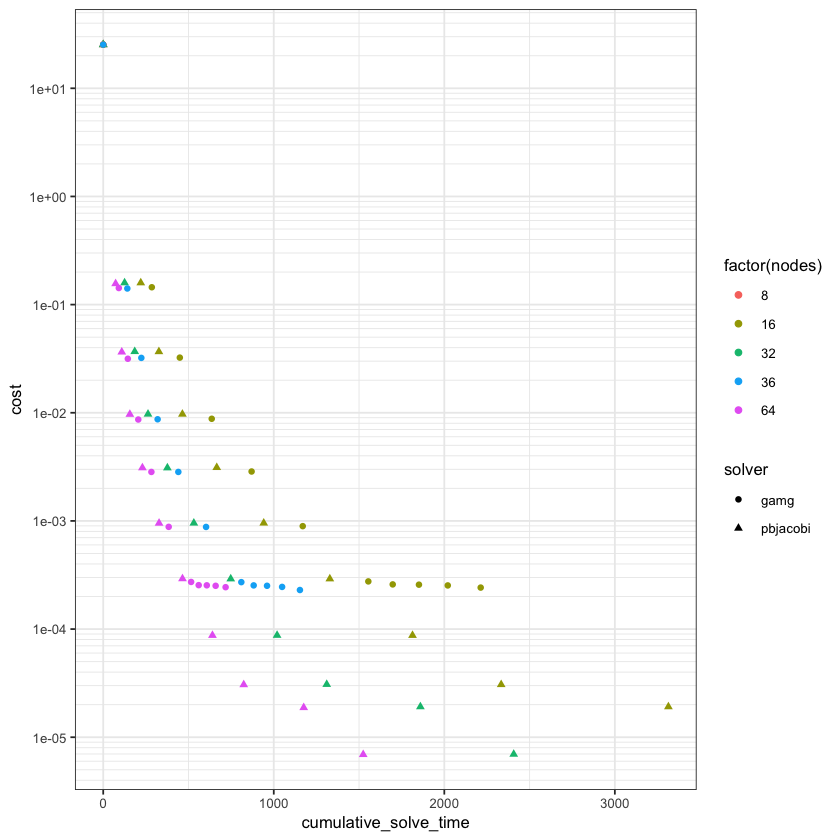

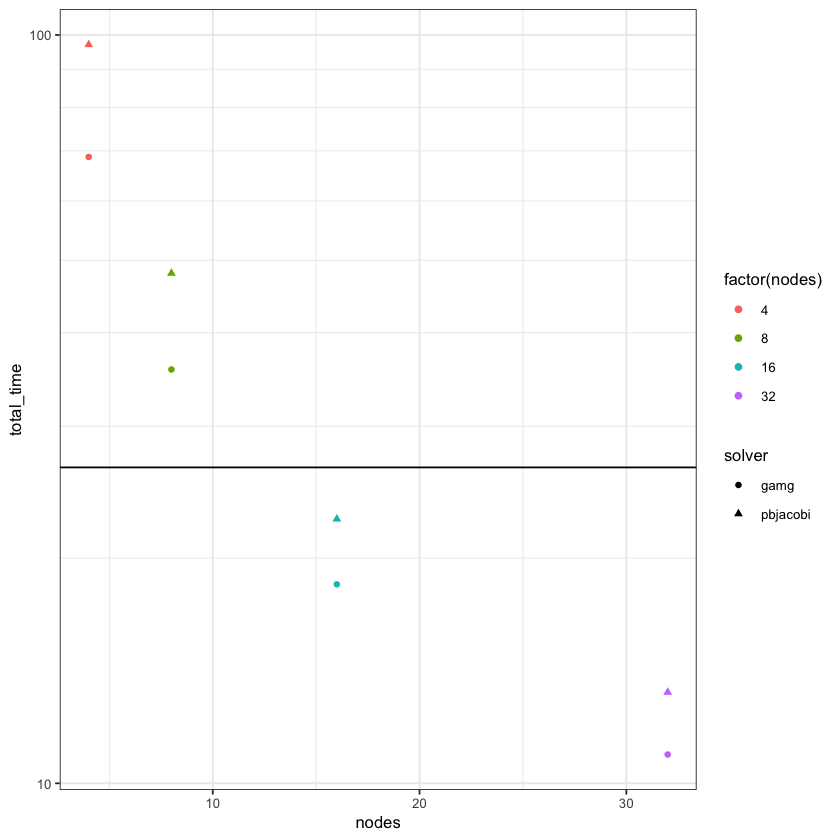

In [5]:
d = df %>% dplyr::filter(bal == "100K-whole-city")
ggplot(d, aes(x=cumulative_solve_time, y=cost, color=factor(nodes), shape=solver)) + geom_point() + scale_y_log_eng()
d = df %>% dplyr::filter(bal == "26K-29K-whole-city-hard") %>% group_by(nodes, solver, bal) %>%
  summarize(total_time=max(cumulative_solve_time))
ceres = read_csv("../ba-problems/26K_29K_whole_city_hard.problem/ceres_benchmark_pbjacobi.csv") %>%
  mutate(ctime = cumsum(solve_time+setup_time)) %>% dplyr::filter(problem <= 10)
ggplot(d, aes(x=nodes, y=total_time, color=factor(nodes), shape=solver)) +
  geom_point() +
  scale_y_log_eng() +
  geom_hline(aes(yintercept=ceres$ctime[11]))

nodes,solver,bal,cameras,total_time
<dbl>,<chr>,<chr>,<dbl>,<dbl>
4,gamg,26K-29K-whole-city-hard,26389,68.70650
4,pbjacobi,26K-29K-whole-city-hard,26389,97.07020
8,gamg,26K-29K-whole-city-hard,26389,35.72530
8,pbjacobi,26K-29K-whole-city-hard,26389,48.03870
16,gamg,100K-whole-city,98925,2213.30000
16,gamg,26K-29K-whole-city-hard,26389,18.44600
16,pbjacobi,100K-whole-city,98925,3313.95000
16,pbjacobi,26K-29K-whole-city-hard,26389,22.55040
32,gamg,26K-29K-whole-city-hard,26389,10.92650


[1] "Writing to ../../thesis/strong_scaling.tex"


pdf 
  2

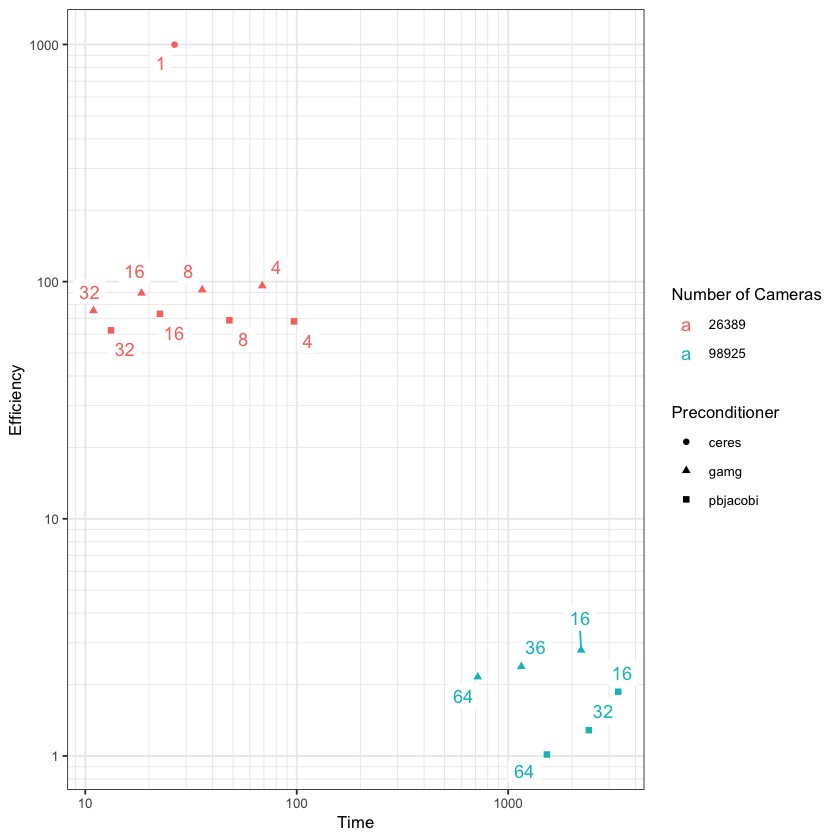

In [8]:
d = df %>% dplyr::filter(!grepl("block", bal)) %>% group_by(nodes, solver, bal) %>%
  summarize(cameras=first(cameras), total_time=max(cumulative_solve_time)) %>%
  dplyr::filter(total_time > 0)
d = bind_rows(d, tibble(nodes=1, solver="ceres", bal="26K-29K-whole-city-hard", cameras=26389, total_time=ceres$ctime[11]))
d
ggplot(d, aes(x=total_time, y=cameras/(total_time*nodes), color=factor(cameras), shape=solver, label=nodes)) +
  geom_point() +
  geom_label_repel(aes(label=nodes),label.size = NA) +
  scale_y_log_eng() +
  scale_x_log_eng() +
  ylab("Efficiency") +
  xlab("Time") +
  labs(color="Number of Cameras", shape="Preconditioner", label="")
tikz_file("../../thesis/strong_scaling.tex", width=6, height=3.5)
ggsave("../../thesis/strong_scaling.pdf", width=6,height=5)

[1] "Writing to ../../thesis/weak_scaling.tex"


pdf 
  2

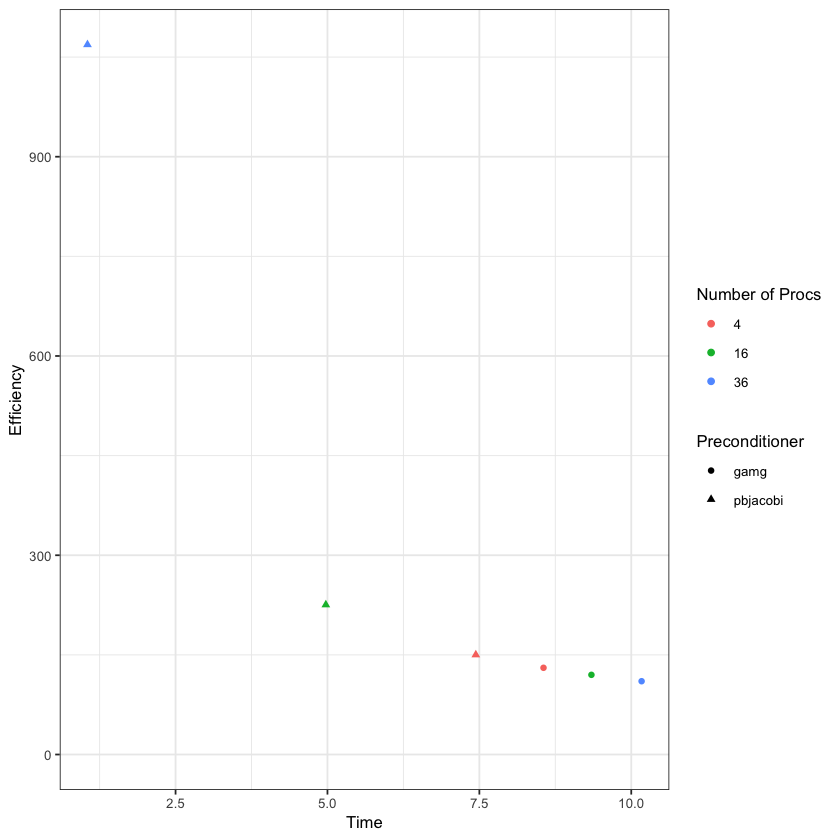

In [7]:
d = df %>% dplyr::filter(grepl("block", bal)) %>% group_by(nodes, solver, bal) %>%
  summarize(cameras=first(cameras), total_time=max(cumulative_solve_time), iters=sum(iters))
ggplot(d, aes(x=total_time, y=cameras/(nodes*total_time), color=factor(nodes), shape=solver)) +
  geom_point() +
  #scale_y_log_eng() +
  #scale_x_log_eng() +
  ylab("Efficiency") +
  xlab("Time") + 
  labs(color="Number of Procs", shape="Preconditioner") +
  ylim(c(0, NA))
tikz_file("../../thesis/weak_scaling.tex", width=4, height=3)
ggsave("../../thesis/weak_scaling.pdf", width=6, height=5)